In [1]:
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
import pandas as pd
import numpy as np
import numpy as np
import grequests
import gevent.monkey
import copy
import shapely
import matplotlib.pyplot as plt

from shapely.geometry import LineString, Point

tqdm.pandas()
gevent.monkey.patch_all()

/var/essdata/IDU/venvs/common_venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_241337/1634903444.py:16: MonkeyPatchWarning: Patching more than once will result in the union of all True parameters being patched
  gevent.monkey.patch_all()


True

### **responses.csv**

In [ ]:
responses = pd.read_csv("responses.csv", delimiter=";")
curricula_vitae = pd.read_csv("curricula_vitae.csv", delimiter=";")

In [4]:
responses = responses[["date_creation", "id_candidate", "id_cv", "id_hiring_organization", "id_response", "id_vacancy", "region_code", "response_type"]]
responses = responses.dropna(subset=["id_cv", "id_vacancy"], how="any")
responses["year"] = responses["date_creation"].apply(lambda x: x.split("-")[0])

print("Responses duplicates:", responses.duplicated().sum())

Responses duplicates: 0


In [5]:
print(responses.groupby("response_type")["id_cv"].count(), '\n')
print(responses.groupby("year")["id_cv"].count())

response_type
Отказ           146829
Приглашение    1384804
Принятие        288255
Name: id_cv, dtype: int64 

year
1970       404
2015     48950
2016    302166
2017    597095
2018    260358
2019    126573
2020    258085
2021    226257
Name: id_cv, dtype: int64


In [6]:
print("Total number of candidates responding to vacacies:", len(responses["id_candidate"].unique()))
print("Total number of vacancies under consideration:", len(responses["id_vacancy"].unique()))

Total number of candidates responding to vacacies: 692769
Total number of vacancies under consideration: 172001


/var/essdata/IDU/venvs/common_venv/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/var/essdata/IDU/venvs/common_venv/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


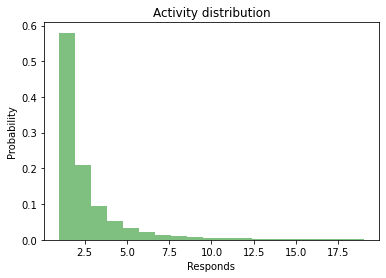

Frequency of applying for a vacancy:
count    692769.000
mean          2.627
std           4.713
min           1.000
25%           1.000
50%           1.000
75%           3.000
max        1187.000
Name: id_vacancy, dtype: float64


In [7]:
freq = responses.groupby(["id_candidate"])["id_vacancy"].count()
q = freq.quantile(0.99)

plt.title("Activity distribution")
plt.xlabel("Responds")
plt.ylabel("Probability")
plt.hist(freq[freq <= q].values, bins=int(q), density = 1, color ='green', alpha = 0.5)
plt.show()

print("Frequency of applying for a vacancy:")
print(freq.describe().round(3))

### **curricula_vitae.csv**

In [8]:
curricula_vitae = curricula_vitae[[
    "id_candidate", "id_cv", "birthday","skills", "additional_skills", "busy_type", "country", "date_creation", "date_publish", 
    "date_modify_inner_info", "education_type", "experience", "gender", "industry_code", "locality", "other_info", 
    "position_name", "profession_code", "relocation", "salary"]]

curricula_vitae = curricula_vitae.drop_duplicates()
curricula_vitae = curricula_vitae.dropna(subset=["locality"])

**define location of CV in each year**

CV is considered active in a year if it was created, published, or modified in this year.   
For some CVs, location tends to change within a year. In this case, the primary location is the location of the longest staying.

In [9]:
cv_years = curricula_vitae[["id_cv", "date_creation", "date_publish", "date_modify_inner_info", "locality"]]

date_columns = ["date_creation", "date_publish", "date_modify_inner_info"]
cv_years = cv_years.astype(dict((c, "datetime64[ns]") for c in date_columns))

# fix mistake when date_creation is later than date_publish or date_modify_inner_info
# new field - fixed_date_creation

cv_years_grouped = cv_years.groupby(["id_cv"])
first_activity = pd.concat((
    cv_years_grouped["date_publish"].min(), cv_years_grouped["date_modify_inner_info"].min()
    ), axis=1).min(axis=1)
date_creation = cv_years_grouped["date_creation"].min()
fixed_date_creation = pd.concat((date_creation, first_activity), axis=1).min(axis=1)
cv_years = cv_years.join(fixed_date_creation.rename("fixed_date_creation"), on="id_cv")

# fillna in the field date_publish, assuming that a resume was published on the day of creation if another date is initially unknown
# corrected field - date_publish

cv_years["date_publish"] = cv_years["date_publish"].fillna(cv_years["date_creation"])
cv_years["date_modify_inner_info"] = cv_years["date_modify_inner_info"].fillna(cv_years["date_publish"])

# define CV's location at the moment of creation

cv_years["year_creation"] = cv_years["fixed_date_creation"].astype("str").str.split("-").str[0]
cv_years = cv_years.join(cv_years.groupby(["id_cv"])["date_modify_inner_info"].min().rename("first_modification"), on="id_cv")
creation_locality = cv_years[cv_years["first_modification"] == cv_years["date_modify_inner_info"]][["id_cv", "year_creation", "locality"]]
creation_locality = creation_locality.drop_duplicates()

# define CV's location at the year of publishing

cv_years["year_publish"] = cv_years["date_publish"].astype("str").str.split("-").str[0]
cv_years["publich_modify_margin"] = (cv_years["date_publish"] - cv_years["date_modify_inner_info"]).abs()
min_margin = cv_years.groupby(["id_cv", "date_publish"])["publich_modify_margin"].min().rename("min_publich_modify_margin")
cv_years = cv_years.join(min_margin, on =["id_cv", "date_publish"])
publish_locality = cv_years[cv_years["publich_modify_margin"] == cv_years["min_publich_modify_margin"]][["id_cv", "year_publish", "locality"]]
publish_locality = publish_locality.drop_duplicates()

# define CV's location of the longest staying in each year

cv_years = cv_years.dropna(subset=["date_modify_inner_info"])
cv_years["year_modification"] = cv_years["date_modify_inner_info"].astype("str").str.split("-").str[0]
cv_years = cv_years.sort_values(["id_cv", "year_modification", "date_modify_inner_info"], ascending=False)
cv_years["modification_margin"] = cv_years.groupby(["id_cv", "year_modification"])["date_modify_inner_info"].diff().dt.days.fillna(0)
cv_years = cv_years.join(
    cv_years.groupby(["id_cv", "year_modification"])["modification_margin"].min().rename("staying"), 
    on=["id_cv", "year_modification"]
    )
staying_locality = cv_years[cv_years["modification_margin"] == cv_years["staying"]][["id_cv", "year_modification", "locality"]]
staying_locality = staying_locality.drop_duplicates()

In [10]:
# define locality for each year of activity

for df in [creation_locality, publish_locality, staying_locality]:
    df.columns = ["id_cv", "year", "locality"]
    df.set_index(["id_cv", "year"], inplace=True)

locality = staying_locality.join(publish_locality, rsuffix="_publish", how="outer")
locality["locality"] = locality["locality"].fillna(locality["locality_publish"])

locality = locality.join(creation_locality, rsuffix="_creation", how="outer")
locality["locality"] = locality["locality"].fillna(locality["locality_creation"])
locality = locality[["locality"]]
locality["locality"] = locality["locality"].astype("int")

**decode kladr to city name**

In [12]:
locality = pd.read_csv("output/curricula_vitae_years.csv")

In [15]:
# create separate table for cities
cv_cities = pd.DataFrame({"kladr": locality["locality"].unique()})

# downloaded KLADR DBs
kladr_2018 = pd.read_csv("data/cities.csv").set_index("Код КЛАДР")
kladr_2021 = pd.read_csv("data/kladr.csv").set_index("code")

# create full column with name of regular cities (city_name), federal cities (name - for Mocsow, SPb and Sevastopol)
# and settelments in case they are not included in bigger city (name)
kladr_2021["city"] = kladr_2021["city_name"].fillna(kladr_2021["name"])

# create row with place' fullest description for yandex geocoder 
description_func = lambda x: (", ".join([x.region_name, x.dist_name, x.city]) if not pd.isnull(x.dist_name) 
                              else ", ".join([x.region_name, x.city]))

kladr_2021.dist_name = kladr_2021.dist_name + " район"
kladr_2021["place_description"] = kladr_2021.apply(description_func, axis=1)

kladr_2018["region_name"] = kladr_2018["Тип региона"] + " " + kladr_2018["Регион"]
kladr_2018["dist_name"] = kladr_2018["Тип района"] + " " + kladr_2018["Район"]
kladr_2018["city"] = kladr_2018["Город"]
kladr_2018 = kladr_2018.dropna(subset=["city"])
kladr_2018["place_description"] = kladr_2018.apply(description_func, axis=1)

cv_cities = cv_cities.join(kladr_2021[["city", "place_description"]], on="kladr")
cv_cities_undefind = cv_cities[cv_cities["city"].isna()]
cv_cities_undefind = cv_cities_undefind[["kladr"]].join(kladr_2018[["city", "place_description"]], on="kladr")
cv_cities_defind = pd.concat((cv_cities[cv_cities["city"].notna()], cv_cities_undefind[cv_cities_undefind["city"].notna()]))

In [15]:
# geocode place description to coordinates
# might need several code runnings with keys shuffling/replacment (due to yandex limits)

from utils.yandex_geocoder import yandex_create_urls, yandex_geocode

with open("./keys.txt") as f:
    api_keys = f.read().splitlines()

urls = []
api_key_counter = 0
for i, adr in enumerate(list(cv_cities_defind["place_description"])):
    if i%24500 == 0 and i != 0:
        api_key_counter += 1
    urls.append(yandex_create_urls(adr, api_keys[api_key_counter]))
yandex_geocoded_data = yandex_geocode(urls)

cities_coordinates = pd.DataFrame(yandex_geocoded_data).replace({0: None})
cv_cities_defind[["x", "y"]] = cities_coordinates[["x", "y"]].to_numpy()
cv_cities_defind = cv_cities_defind.sort_index()

100%|██████████| 582/582 [14:45<00:00,  1.52s/it]


In [31]:
# kladr numbers that couldn't be decoded with DB's
cv_cities_undefind =  cv_cities_undefind[cv_cities_undefind["city"].isna()]

In [36]:
from utils.dadata_decoder import dadata_create_request, dadata_decode_kladr


# decode kladr numbers and get coordinates with dadata service

with open("./dadata_token.txt") as f:
    token = f.read().splitlines()
    
requests = []
for i, kladr in enumerate(list(cv_cities_undefind["kladr"])):
    requests.append(dadata_create_request(kladr, token[1]))
dadata_decoded_data = dadata_decode_kladr(requests)

cv_cities_undefind = cv_cities_undefind.set_index("kladr")

cities_coordinates = pd.DataFrame(dadata_decoded_data, index=list(cv_cities_undefind.index)).replace({0: None})
cities_coordinates = cities_coordinates[cities_coordinates["x"].notna()]
cities_coordinates["city"] = cities_coordinates["city"].fillna(cities_coordinates["settlement"])
cities_coordinates["place_description"] = cities_coordinates["region"] + ", " + cities_coordinates["city"] 

cv_cities_undefind.loc[cities_coordinates.index, ["city", "place_description", "x", "y"]] = cities_coordinates[["city", "place_description", "x", "y"]]

100%|██████████| 184/184 [02:10<00:00,  1.41it/s]


In [ ]:
# repeat the process of decoding several times (for some reason dadata can not decode all at once)

while len(cities_coordinates) > 0:
    with open("./dadata_token.txt") as f:
        token = f.read().splitlines()
        
    requests = []
    for i, kladr in enumerate(list(cv_cities_undefind[cv_cities_undefind["city"].isna()].index)):
        requests.append(dadata_create_request(kladr, token[0]))
    dadata_decoded_data = dadata_decode_kladr(requests)

    if cities_coordinates["x"].notna().any():
        cities_coordinates = pd.DataFrame(
            dadata_decoded_data, index=list(cv_cities_undefind[cv_cities_undefind["city"].isna()].index)
            ).replace({0: None})
        cities_coordinates = cities_coordinates[cities_coordinates["x"].notna()]
        cities_coordinates["city"] = cities_coordinates["city"].fillna(cities_coordinates["settlement"])
        cities_coordinates["place_description"] = cities_coordinates["region"] + ", " + cities_coordinates["city"]

        cv_cities_undefind.loc[cities_coordinates.index, ["city", "place_description", "x", "y"]] = cities_coordinates[["city", "place_description", "x", "y"]]
        cv_cities_undefind = cv_cities_undefind.dropna(subset=["x", "y"])

In [70]:
cv_cities_decoded = pd.concat((cv_cities_defind, cv_cities_undefind.reset_index()))

print("Decodes CVs:", len(cv_cities_decoded), f"({round(len(cv_cities_decoded) / len(cv_cities), 2)} %)")
print("Undecoded CVs:", len(cv_cities) - len(cv_cities_decoded), f"({(round((len(cv_cities) - len(cv_cities_decoded)) / len(cv_cities), 2))} %)")

Decodes CVs: 63487 (0.94 %)
Undecoded CVs: 3892 (0.06 %)


**select unique CVs**

In [16]:
# drop CV duplicates taking (first) the fullest and (second) the recent version of resume 

curricula_vitae = curricula_vitae.drop(["locality"], axis=1)

# split df into duplicatded and unique parts
cv_duplicates_mask = curricula_vitae["id_cv"].isin(curricula_vitae["id_cv"][curricula_vitae["id_cv"].duplicated()].unique())
cv_duplicates = curricula_vitae[cv_duplicates_mask]
cv_duplicates = cv_duplicates.astype({"date_modify_inner_info": "datetime64[ns]"})

# find the fullest rows
count_nan = pd.concat((cv_duplicates["id_cv"], cv_duplicates.isna().sum(axis=1).rename("count_nan")), axis=1)
min_nan = count_nan.groupby("id_cv").min().rename(columns={"count_nan": "min_nan"})
count_nan = count_nan.join(min_nan, on="id_cv")
cv_fullest_rows = cv_duplicates[count_nan["count_nan"] == count_nan["min_nan"]]

# leave the fullest rows updated most recently
recent_activity = cv_fullest_rows.groupby("id_cv")["date_modify_inner_info"].max().rename("recent_activity")
recent_activity = cv_fullest_rows[["id_cv", "date_modify_inner_info"]].join(recent_activity, on="id_cv")
cv_last_activity = cv_fullest_rows[recent_activity["date_modify_inner_info"] == recent_activity["recent_activity"]]
cv_duplicated_unique = cv_last_activity.drop_duplicates(subset=["id_cv"], keep="first")

# merge two part into one dataset
cv_duplicated_unique = cv_duplicated_unique.astype({"date_modify_inner_info": "datetime64[ns]"})
curricula_vitae_unique = pd.concat((curricula_vitae[~cv_duplicates_mask], cv_duplicated_unique)).reset_index(drop=True)

print("CV duplicates:", curricula_vitae_unique["id_cv"].duplicated().sum())

CV duplicates: 0


**merge CVs with education and work experience**

In [17]:
cv_professions = curricula_vitae_unique[["id_candidate", "id_cv", "position_name", "industry_code", "skills", "additional_skills", "other_info", "profession_code"]]
(cv_professions.notna().sum() / len(cv_professions)).round(3)

id_candidate         1.000
id_cv                1.000
position_name        0.998
industry_code        1.000
skills               0.284
additional_skills    0.349
other_info           0.070
profession_code      0.432
dtype: float64

In [18]:
cv_edu = pd.read_csv("data/edu.csv", delimiter=";")
cv_edu = cv_edu[["faculty", "id_cv", "qualification", "speciality"]]
cv_edu = cv_edu.drop_duplicates()

workexp = pd.read_csv("data/workexp.csv", delimiter=";")
workexp = workexp[["id_cv", "job_title", "demands"]]
workexp = workexp.drop_duplicates()

In [19]:
# for each column: find duplicates, add separator to each row, sum strings under the same index and drop last hanging separator

def join_inf(df, index, column, sep=" \ "):

    df = df[[index, column]].dropna().drop_duplicates()
    df[column] = df[column] + sep
    df = df.groupby([index])[column].sum()
    df = df.str.rstrip(sep)

    return df

new_columns = list(map(lambda x: join_inf(cv_edu, "id_cv", x), cv_edu.set_index("id_cv").columns))
edu_joint = pd.concat(new_columns, axis=1)
cv_professions = cv_professions.join(edu_joint, on="id_cv")

new_columns = list(map(lambda x: join_inf(workexp, "id_cv", x), workexp.set_index("id_cv").columns))
workexp_joint = pd.concat(new_columns, axis=1)
cv_professions = cv_professions.join(workexp_joint, on="id_cv")

### **vacancies.csv**

In [2]:
vacancies = pd.read_csv("data/vacancies.csv", delimiter=";")
vacancies = vacancies.drop_duplicates()
vacancies = vacancies[["identifier", "title", "id_hiring_organization", "industry", "profession", "region", 
           "job_location_address", "job_location_geo_longitude", "job_location_geo_latitude", "okso_code",
           "date_creation", "date_posted", "date_modify_inner_info"]]

organizations = pd.read_csv("data/organizations.csv", delimiter=";")

/tmp/ipykernel_3597418/491186538.py:1: DtypeWarning: Columns (1,6,28,41,46,53,61,65,67,70) have mixed types. Specify dtype option on import or set low_memory=False.
  vacancies = pd.read_csv("data/vacancies.csv", delimiter=";")
/tmp/ipykernel_3597418/491186538.py:7: DtypeWarning: Columns (36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  organizations = pd.read_csv("data/organizations.csv", delimiter=";")


In [88]:
## select recent ones from duplicated

vacancies["job_location_geo_longitude"] = vacancies["job_location_geo_longitude"].round(2)
vacancies["job_location_geo_latitude"] = vacancies["job_location_geo_latitude"].round(2)

vacancies_copy = copy.deepcopy(vacancies).drop_duplicates(
    subset=["identifier", "job_location_address", "job_location_geo_longitude", "job_location_geo_latitude"]
    )

date_columns = ["date_creation", "date_posted", "date_modify_inner_info"]
vacancies_copy = vacancies_copy.astype(dict((c, "datetime64[ns]") for c in date_columns))

vacancies_copy = vacancies_copy.sort_values(by=["date_modify_inner_info", "date_posted", "date_creation", "job_location_geo_latitude"])
vacancies_copy =  vacancies_copy.groupby(["identifier"]).first()

In [89]:
kladr_2021 = pd.read_csv("data/kladr.csv").set_index("code")
kladr_2021["city"] = kladr_2021["city_name"].fillna(kladr_2021["name"])

regions = list(kladr_2021["region_name"].unique())
regions = pd.Series(regions)
regions = regions.replace({
    'Республика Татарстан (Татарстан)': 'Республика Татарстан', 
    'Ханты-Мансийский автономный округ – Югра': 'Ханты-Мансийский автономный округ - Югра',
    'Чувашская Республика - Чувашия': 'Чувашская Республика'
    })

cities_name = np.array(kladr_2021["city"][kladr_2021["city"].notna()].unique())

# fill coordinates for regional ciities
vacancies_copy["city"] = None

coord_columns = ["job_location_geo_longitude", "job_location_geo_latitude", "city"]
vacancies_copy.loc[vacancies_copy["job_location_address"] == "г. Москва", coord_columns] = [37.618423, 55.751244, 'Москва']
vacancies_copy.loc[vacancies_copy["job_location_address"] == "г. Санкт-Петербург", coord_columns] = [30.3350986, 59.9342802, 'Санкт-Петербург']
vacancies_copy.loc[vacancies_copy["job_location_address"] == "г. Севастополь", coord_columns] = [33.535667, 44.629650, 'Севастополь']

# defines rows that contains information only about region
vacancies_nocoord = vacancies_copy[vacancies_copy["job_location_geo_longitude"].isna()]
vacancies_only_region = vacancies_nocoord[vacancies_nocoord["job_location_address"].isin(regions)]
vacancies_bad_address = vacancies_nocoord[~vacancies_nocoord["job_location_address"].isin(regions)]

# extract cities from unstructured address row

def preprocess_str(series):
    return series.copy().str.split(",").str.join(" ").str.split(";").str.join(" ") + " "

def get_city(loc, cities_name):
    city = cities_name[np.array([" " + c + " " in loc for c in cities_name])]
    if len(city) > 0:
        return city[0]

job_location_address_fixed = preprocess_str(vacancies_bad_address["job_location_address"])
city_match = job_location_address_fixed.progress_apply(lambda loc: get_city(loc, cities_name))
vacancies_copy.loc[city_match.index, "city"] = city_match


100%|██████████| 1665/1665 [01:40<00:00, 16.59it/s]


In [90]:
undefined_address = pd.concat((vacancies_only_region, vacancies_copy.loc[city_match[city_match.isna()].index]))
undefined_address = undefined_address.join(
    organizations.set_index("id_organization")[["inn", "ogrn"]], on="id_hiring_organization"
    )
undefined_address["org_code"] = undefined_address["inn"].fillna(undefined_address["ogrn"])
undefined_address = undefined_address.dropna(subset=["org_code"])
org_codes = list(undefined_address['org_code'].astype("int").unique())

In [14]:
from utils.dadata_organizations import dadata_create_request, dadata_decode_organization

# decode organization address by its inn/ogrn

with open("./dadata_token.txt") as f:
    token = f.read().splitlines()
    
requests = []
for i, code in enumerate(org_codes):
    requests.append(dadata_create_request(code, token[1]))
dadata_decoded_data = dadata_decode_organization(requests)

100%|██████████| 517/517 [04:27<00:00,  1.93it/s]


In [91]:
# copy city name and lat/long to initial dataset with vacancies

org_adress = pd.DataFrame(dadata_decoded_data)
org_adress["code"] = org_codes
org_adress["city"] = org_adress["city"].fillna(org_adress["settlement"])
org_adress = org_adress.set_index("code")

undefined_address["org_code"] = undefined_address["org_code"].astype("int")
undefined_address = undefined_address.reset_index().set_index("org_code")
undefined_address.loc[org_adress.index, "city"] = org_adress['city']
undefined_address.loc[org_adress.index, "job_location_geo_latitude"] = org_adress['geo_lat']
undefined_address.loc[org_adress.index, "job_location_geo_longitude"] = org_adress['geo_lon']
undefined_address = undefined_address.reset_index().set_index("identifier")

undefined_address = undefined_address.dropna(subset=["city"])
vacancies_copy.loc[undefined_address.index, "city"] = undefined_address["city"]
vacancies_copy.loc[undefined_address.index, "job_location_geo_latitude"] = undefined_address["job_location_geo_latitude"]
vacancies_copy.loc[undefined_address.index, "job_location_geo_longitude"] = undefined_address["job_location_geo_longitude"]

vacancies_copy = vacancies_copy.dropna(subset=["city", "job_location_geo_longitude", "job_location_geo_latitude"], how="all")
vacancies_coord = vacancies_copy[vacancies_copy["city"].isna()]

In [8]:
from utils.yandex_geocoder import yandex_create_urls, yandex_geocode

# geocode coordinates to cities/settelments

all_coords = vacancies_coord[["job_location_geo_longitude", "job_location_geo_latitude"]].to_numpy()
unique_coords = np.unique(all_coords, axis=0)
unique_coords_str = list(map(lambda x: str(x[0]) + "," + str(x[1]), unique_coords.tolist()))

with open("./keys_1.txt") as f:
    api_keys = f.read().splitlines()

urls = []
api_key_counter = 0
for i, adr in enumerate(unique_coords_str):
    if i%24500 == 0 and i != 0:
        api_key_counter += 1
    urls.append(yandex_create_urls(adr, api_keys[api_key_counter]))
yandex_geocoded_data = yandex_geocode(urls)

100%|██████████| 1212/1212 [28:33<00:00,  1.41s/it]


In [ ]:
vacancies_city = pd.DataFrame(yandex_geocoded_data)
vacancies_city["coords"] = unique_coords_str
vacancies_city = vacancies_city.replace({0: np.nan})
vacancies_city["locality"] = vacancies_city["locality"].fillna(vacancies_city["name"])

vacancies_copy["coords"] = vacancies_copy["job_location_geo_longitude"].astype("str") + "," + vacancies_copy["job_location_geo_latitude"].astype("str")
vacancies_copy = vacancies_copy.join(vacancies_city.set_index("coords")["locality"], on="coords")
vacancies_copy["city"] = vacancies_copy["city"].fillna(vacancies_copy["locality"])
vacancies_copy = vacancies_copy[vacancies_copy["city"].notna()]

In [48]:
cities_without_coord = list(vacancies_copy[vacancies_copy["job_location_geo_latitude"].isna()]["city"].unique())

In [58]:
from utils.yandex_geocoder import yandex_create_urls, yandex_geocode

# geocode cities to coords (to fill nan value in dataset)

cities_without_coord = list(vacancies_copy[vacancies_copy["job_location_geo_latitude"].isna()]["city"].unique())

with open("./keys_1.txt") as f:
    api_keys = f.read().splitlines()
api_keys.reverse()

urls = []
api_key_counter = 0
for i, adr in enumerate(cities_without_coord):
    if i%24500 == 0 and i != 0:
        api_key_counter += 1
    urls.append(yandex_create_urls(adr, api_keys[api_key_counter]))
yandex_geocoded_data = yandex_geocode(urls)

city_coords = pd.DataFrame(yandex_geocoded_data)
city_coords["city"] = cities_without_coord
city_coords = city_coords[city_coords["yand_adr"] != 0]

100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


In [ ]:
vacancies_copy = vacancies_copy.join(city_coords.set_index("city")[["x", "y"]], on="city")
vacancies_copy["job_location_geo_latitude"] = vacancies_copy["job_location_geo_latitude"].fillna(vacancies_copy["x"])
vacancies_copy["job_location_geo_longitude"] = vacancies_copy["job_location_geo_longitude"].fillna(vacancies_copy["y"])
vacancies_copy = vacancies_copy[vacancies_copy["job_location_geo_latitude"].notna()]
vacancies_copy = vacancies_copy.drop(["coords", "locality", "x", "y"], axis=1)